In [16]:
import os
import sys
direct='../'
exec(open('../LoadData.py').read())

In [1]:
from dpcomp_core.algorithm import *
from dpcomp_core.query_nd_union import ndRangeUnion
from dpcomp_core import workload
algs = [dawa.dawa_engine(), 
        identity.identity_engine(), 
        HB.HB_engine()
       ]

In [18]:
from sklearn.neighbors import KernelDensity

/home/jacob/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if 'order' in inspect.getargspec(np.copy)[0]:


In [4]:
kde = KernelDensity().fit(adult.train[0][:, np.newaxis])

In [5]:
X_plot = np.linspace(-1, 100, 8192)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)

In [6]:
dens = np.exp(log_dens)
dens = dens.reshape((4096, -1)).sum(axis=1).flatten()

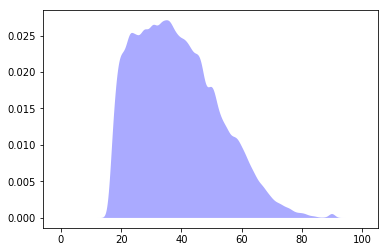

In [7]:
fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')

In [19]:
def set_1Ddb_params(col, scale, dom_size, bounds):
    lb, ub = bounds
    kde = KernelDensity().fit(col[:, None])
    X_samples = np.exp(kde.score_samples(np.linspace(lb, ub, 8192)[:, None]))
    hist = X_samples.reshape((dom_size, -1)).sum(axis=1).flatten()
    hist = hist*scale/hist.sum()
    return np.around(hist).astype('int')

In [9]:
H = set_1Ddb_params(adult.train[0], 1000, 256, (16, 100))

In [10]:
(H == 0).sum()
tvd = abs(H-H.mean()).sum()/2
tvd

410.5

In [7]:
from dpcomp_core.algorithm.dawa import l1partition
from dpcomp_core import experiment
from dpcomp_core import metric
from dpcomp_core import dataset

def run_alg(X, W, A, seed, epsilon=1):
    M = metric.SampleError(experiment.Single(X, W, A, epsilon, seed))
    err = M.compute()
    return err

def seeder(seed=12345):
    prng = np.random.RandomState(seed)
    while(True):
        yield prng.randint(0, 2**32)

def dev(H):
    return abs(H-H.mean()).sum()

def collect_data(dbname):
    epsilon=1
    S = seeder()
    D = pd.DataFrame()
    for dom_size in 2**np.arange(7, 13):
        for scale in 2**np.arange(5, 25):
            #dom_size, scale, nnz, tv, partitionality
            #H = set_1Ddb_params(adult.train[0], scale, dom_size, (16, 100))
            X = dataset.DatasetSampledFromFile(nickname=dbname, sample_to_scale=int(scale),\
                                               reduce_to_dom_shape=int(dom_size), seed=next(S))
            H = (X.dist*X.scale).astype('int')
            nnz = (H == 0).sum()
            tvd = dev(H)
            P = l1partition.L1partition(H, epsilon, gethist=True, seed=next(S))
            cost = sum([dev(H[l:r+1]) for l, r in P]) + len(P)/epsilon
            W1 = workload.Identity((dom_size,))
            W2 = workload.Prefix1D(domain_shape_int=dom_size)
            alg_perf1 = [run_alg(X, W1, a, epsilon, next(S)) for a in algs]
            alg_perf2 = [run_alg(X, W2, a, epsilon, next(S)) for a in algs]
            E = [dom_size, scale, nnz, tvd, cost, 0] + alg_perf1 + \
                [dom_size, scale, nnz, tvd, cost, 1] + alg_perf2
            E = pd.DataFrame(np.array(E).reshape((2, -1)))
            D = D.append(E, ignore_index=True)
    D.columns = ['domsize', 'scale', 'nnz', 'tvd', 'partcost', 'wkloadhalf', 'dawaerr', 'iderr', 'hberr']
    D['dbname'] = dbname
    return D

In [8]:
X = dataset.DatasetSampledFromFile(nickname='ADULT', sample_to_scale=int(1024),\
                                               reduce_to_dom_shape=int(1024), seed=12435)
W1 = workload.Identity((1024,))
E = run_alg(X, W1, algs[0], 1, 1234)

In [17]:
algs[0].Run(W1, (X.dist*X.scale).astype(int), 1, 12345)

array([ 9.72462156e+02,  1.01184747e+00,  1.01184747e+00, ...,
       -2.25545580e-03, -2.25545580e-03, -2.25545580e-03])

In [23]:
X

In [3]:
Dadult = collect_data('ADULT')

In [4]:
Dhepth = collect_data('HEPTH')

In [5]:
Dincome = collect_data('INCOME')

In [6]:
Dmedcost = collect_data('MEDCOST')

In [7]:
Dnettrace = collect_data('NETTRACE')

In [8]:
Dsearchlogs = collect_data('SEARCHLOGS')

In [9]:
Dpatent = collect_data('PATENT')

In [19]:
import pickle
P = pd.concat([Dadult, Dhepth, Dincome, Dmedcost, Dnettrace, Dsearchlogs, Dpatent], ignore_index=True)
pickle.dump(P, open('hist1D.p', 'wb'))

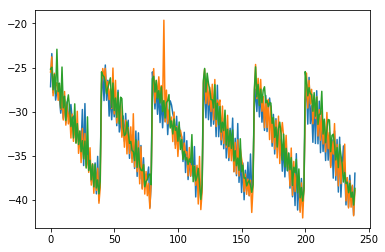

In [14]:
plt.plot(np.log(Dadult[['dawaerr', 'iderr', 'hberr']]))

In [14]:
dom_size = 8192
scale=32
dbname='BIDS-ALL'
S = seeder()
epsilon=1
X = dataset.DatasetSampledFromFile(nickname=dbname, sample_to_scale=int(scale),\
                                   reduce_to_dom_shape=int(dom_size), seed=next(S))
H = (X.dist*X.scale).astype('int')
nnz = (H == 0).sum()
tvd = dev(H)
P = l1partition.L1partition(H, epsilon, gethist=True, seed=next(S))
cost = sum([dev(H[l:r+1]) for l, r in P]) + len(P)/epsilon
W1 = workload.Identity((dom_size,))
W2 = workload.Prefix1D(domain_shape_int=dom_size)
run_alg(X, W2, algs[0], epsilon, next(S))
#dawa.dawa_engine().Run(W2, H, 1, 12345)

AssertionError: Domain must be reducible to target domain by uniform grid: 0, 4096

In [10]:
X = dataset.DatasetSampledFromFile(nickname=dbname, sample_to_scale=int(scale),\
                                   reduce_to_dom_shape=int(dom_size), seed=next(S))

In [12]:
scale

32

In [13]:
epsilon = 1
P = l1partition.L1partition(H, epsilon, gethist=True, seed=123)
cost = sum([dev(H[l:r+1]) for l, r in P]) + len(P)/epsilon
cost

74.67279309384571

In [184]:
X1 = dataset.DatasetSampledFromFile(nickname='BIDS-ALL', sample_to_scale=1e4, reduce_to_dom_shape=1024, seed=111)
W1 = workload.Prefix1D(domain_shape_int=1024)
#W1 = workload.Identity((1024,))
A = algs[0]
M = metric.SampleError(experiment.Single(X1, W1, A, 1, 12345))
err = M.compute().error_payload
err

{'TypeI.Linf': 0.007090698977572538,
 'TypeI.L1': 0.0025155701215062425,
 'TypeI.L2': 9.161779731020808e-05}

In [154]:
#X1 = dataset.DatasetSampledFromFile(nickname='BIDS-ALL', sample_to_scale=1e4, reduce_to_dom_shape=1024, seed=111)
#W1 = workload.Prefix1D(domain_shape_int=1024)
A = algs[1]
M = metric.SampleError(experiment.Single(X1, W1, A, 1, 12345))
err = M.compute().error_payload
err

{'TypeI.Linf': 0.0028556712012473553,
 'TypeI.L1': 0.0008309170412841024,
 'TypeI.L2': 3.127345704396493e-05}

In [63]:
W1 = workload.Prefix1D(domain_shape_int=1024)
A = uniform.uniform_engine()

In [64]:
E = experiment.Single(X1, W1, A, 1, 12345)

In [50]:
E.X_hat

In [51]:
E = E.run()

In [68]:
M1 = metric.SampleError(E)

In [70]:
M1.compute()

In [71]:
M1.asDict()

{'init_params': {'E': {'marshaled': True,
   'class': 'dpcomp_core.experiment.Single',
   'init_params': {'seed': 12345,
    'epsilon': 1,
    'A': {'marshaled': True,
     'class': 'dpcomp_core.algorithm.uniform.uniform_engine',
     'init_params': {}},
    'W': {'marshaled': True,
     'class': 'dpcomp_core.workload.Prefix1D',
     'init_params': {'pretty_name': 'prefix 1D', 'domain_shape_int': 1024}},
    'X': {'marshaled': True,
     'class': 'dpcomp_core.dataset.DatasetSampledFromFile',
     'init_params': {'seed': 111,
      'reduce_to_dom_shape': 1024,
      'sample_to_scale': 10000.0,
      'nickname': 'BIDS-ALL'}}}}},
 'E': <dpcomp_core.experiment.Single at 0x7f70d1f92748>,
 'X': <dpcomp_core.dataset.DatasetSampledFromFile at 0x7f70d1e23908>,
 'X_hat': array([9.765625, 9.765625, 9.765625, ..., 9.765625, 9.765625, 9.765625],
       dtype=float32),
 'W': Prefix1D(domain_shape_int=1024),
 'error_payload': {'TypeI.Linf': 0.015953125,
  'TypeI.L1': 0.00590247802734375,
  'TypeI.L2'